In [6]:
!pip install slideio

  Obtaining dependency information for slideio from https://files.pythonhosted.org/packages/67/49/6a77c87983ec5bbd4a288ccd7d2064b5c11c3ceb995d499de1a81e05a920/slideio-2.3.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.6/48.6 MB 14.6 MB/s eta 0:00:00m eta 0:00:010:01:01


In [3]:
# import scipy
# import sklearn
# from sklearn.feature_extraction import image
from scipy.io import loadmat
import matplotlib.pyplot as plt
from einops import rearrange
import numpy as np
import mat73
import h5py
import rasterio
import os
import slideio
import torch
from torchvision.transforms import (
    Compose,
    RandomApply,
    RandomHorizontalFlip,
    RandomRotation,
    RandomVerticalFlip,
    Resize,
    InterpolationMode
)

In [4]:
def trim_seg_mask(seg_mask):
    h, w, c = seg_mask.shape
    # left limit
    for i in range(w):
        if np.mean(seg_mask[:, i, :]) < 255:
            break

    # right limit
    for j in range(w - 1, 0, -1):
        if np.mean(seg_mask[:, j, :]) < 255:
            break

    # top limit
    for k in range(h):
        if np.mean(seg_mask[k, :, :]) < 255:
            break

    # bottom limit
    for v in range(h - 1, 0, -1):
        if np.mean(seg_mask[v, :, :]) < 255:
            break

    cropped = seg_mask[k:(v + 1), i:(j + 1), :].copy()
    return cropped


def binary_seg_mask(seg_mask):
    h,w,c = seg_mask.shape
    binary_mask = np.zeros_like(seg_mask)[:, :, 0]
    for i in range(h):
        for j in range(w):
            if np.mean(seg_mask[i, j, :]) > 250:
                binary_mask[i, j] = 1

    return binary_mask

In [27]:
# image = scipy.io.loadmat('ganglia_annotations/S00-1910_certainGanglia_P1.mat')
f = h5py.File('ganglia_annotations/S00-1910_certainGanglia_P1.mat', 'r')
print(f.keys()) # <KeysViewHDF5 ['X', 'y']>  
print(f['mask'][:])

<KeysViewHDF5 ['mask']>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [5]:
data_dict = mat73.loadmat('ganglia_mat_files/S00-1910_potentialGanglia_P1.mat')

# image = scipy.io.loadmat(image_url)

In [6]:
a = torch.ByteTensor(data_dict['mask'])
a = a.unsqueeze(dim=2)

In [93]:
nx = a.numpy()
nx

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)

In [139]:
np.where(nx == 0)

(array([0, 0, 0, ..., 0, 0, 0]),
 array([    0,     0,     0, ..., 26213, 26213, 26213]),
 array([    0,     1,     2, ..., 15982, 15983, 15984]))

In [109]:
1 in nx

True

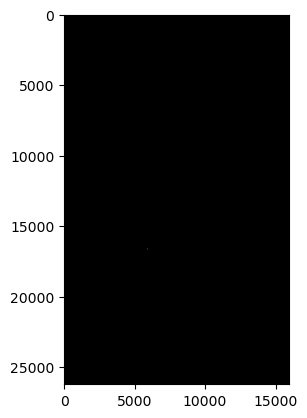

In [76]:
plt.imshow(rearrange(a, 'c h w -> h w c'), cmap='gray')
plt.show()

In [36]:
ganglia = torch.ByteTensor(mat73.loadmat(f'ganglia_mat_files/S00-1910_potentialGanglia_P1.mat')['mask']).unsqueeze(dim=2)
print(ganglia.shape) # torch.Size([26214, 15985, 1])

torch.Size([26214, 15985, 1])


In [35]:
np_ganglia = ganglia.numpy()
np_ganglia

array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]]], dtype=uint8)

In [110]:
np.where(np_ganglia == 1), 1 in np_ganglia

((array([0, 0, 0, ..., 0, 0, 0]),
  array([ 3632,  3632,  3632, ..., 12668, 12668, 12668]),
  array([8278, 8279, 8280, ..., 7648, 7649, 7650])),
 True)

In [69]:
ganglia = ganglia.unsqueeze(dim=0)

In [111]:
print(ganglia.shape)

torch.Size([1, 26214, 15985])


In [8]:
torch.save(obj=ganglia, f='ganglia_annotations/ctest.pt')
torch.save(obj=a, f='ganglia_annotations/ptest.pt')

In [9]:
ctest = torch.load("ganglia_annotations/ctest.pt")
ptest = torch.load("ganglia_annotations/ptest.pt")
print(ctest.shape), print(ptest.shape)

torch.Size([26214, 15985, 1])
torch.Size([26214, 15985, 1])


(None, None)

In [138]:
1 in ctest[0][0]

False

In [10]:
test = ctest + ptest 
test.shape

torch.Size([26214, 15985, 1])

In [11]:
import torch
torch_obj = torch.load(f'10x_images_segmentations/S00-1910.pt')

In [18]:
(rearrange(test, 'h w c -> c h w')).shape, torch_obj["img"].shape

(torch.Size([1, 26214, 15985]), torch.Size([3, 13107, 7992]))

In [19]:
test = rearrange(test, 'h w c -> c h w')

In [29]:
test = Resize(size=(torch_obj['img'].shape[1], torch_obj['img'].shape[2]), interpolation=InterpolationMode.NEAREST)(test)
test.shape


torch.Size([1, 13107, 7992])

In [30]:
torch_obj["gang"] = test

In [31]:
torch.save(obj=torch_obj, f='10x_images_segmentations_with_ganglia/S00-1910.pt')

In [32]:
obj_ = torch.load(f'10x_images_segmentations_with_ganglia/S00-1910.pt')

In [33]:
obj_["img"].shape, obj_["muscle"].shape, obj_["plexus"].shape, obj_["gang"].shape

(torch.Size([3, 13107, 7992]),
 torch.Size([1, 13107, 7992]),
 torch.Size([1, 13107, 7992]),
 torch.Size([1, 13107, 7992]))

In [125]:
image_paths = os.listdir('raw_images')
full_image_path = f'raw_images/S00-1910.svs'
slide = slideio.open_slide(full_image_path, 'SVS')
scene = slide.get_scene(0)
ds_image = torch.ByteTensor(scene.read_block())

In [163]:
muscle_path = 'muscle_and_plexus_annotations/S00-1910_GTmuscMask.tif'
plexus_path = 'muscle_and_plexus_annotations/S00-1910_plexinc.tif'

In [164]:
with rasterio.open(muscle_path) as f:
        musc_array = f.read().transpose(1, 2, 0)

In [165]:
    with rasterio.open(plexus_path) as f:
        plexus_array = f.read().transpose(1, 2,0)

In [175]:
cropped_musc = trim_seg_mask(musc_array)
cropped_plexus = trim_seg_mask(plexus_array)
binary_musc = torch.ByteTensor(binary_seg_mask(cropped_musc))
binary_plexus = torch.ByteTensor(binary_seg_mask(cropped_plexus))

In [176]:
musc_array.shape, cropped_musc.shape, binary_musc.shape

((1430, 1050, 3), (1282, 781, 3), torch.Size([1282, 781]))

In [177]:
img = rearrange(ds_image, 'h w c -> c h w')
img = Resize(size=(int(img.shape[1]/2), int(img.shape[2]/2)), interpolation=InterpolationMode.NEAREST)(img)

In [179]:
muscle = Resize(size=(img.shape[1], img.shape[2]), interpolation=InterpolationMode.NEAREST)(rearrange(binary_musc, 'h w -> 1 h w'))


In [180]:
print(ds_image.shape, img.shape, musc_array.shape, muscle.shape, plexus_array.shape, test.shape)

torch.Size([26214, 15985, 3]) torch.Size([3, 13107, 7992]) (1430, 1050, 3) torch.Size([1, 13107, 7992]) (1430, 1050, 3) torch.Size([26214, 15985, 1])


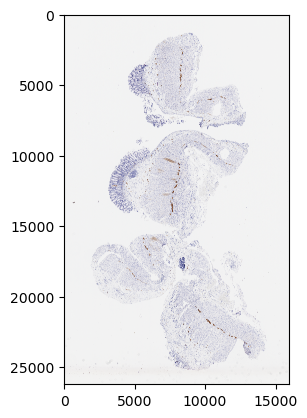

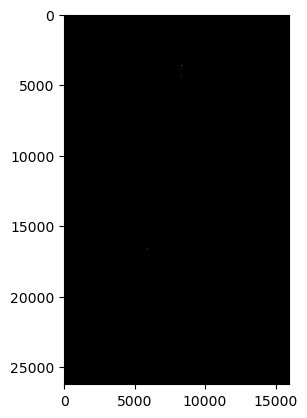

TypeError: Invalid shape (15985, 1, 26214) for image data

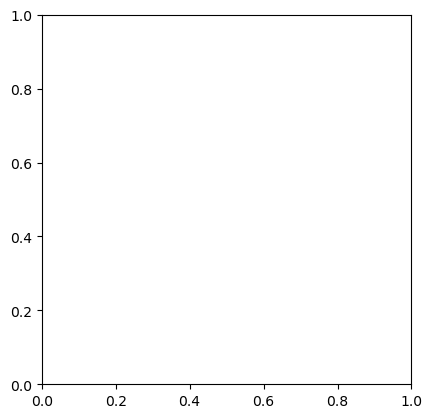

In [149]:
plt.imshow(ds_image, cmap='gray')
plt.show()

plt.imshow(test, cmap='gray')
plt.show()


In [21]:


image_paths = os.listdir('/windows/histo/raw_images')
for i_path, image_path in enumerate(image_paths):
    full_image_path = f'/windows/histo/raw_images/{image_path}'
    slide = slideio.open_slide(full_image_path, 'SVS')
    scene = slide.get_scene(0)
    ds_image = torch.ByteTensor(scene.read_block())

    file_id = image_path.replace('.svs', '')
    ganglia = torch.ByteTensor(mat73.loadmat(f'/windows/histo/ganglia/{file_id}_certainGanglia_P1.mat')['mask'])
    print(ganglia.shape, ds_image.shape)

    new_h = int(plexus.shape[0] / 2)
    new_w = int(plexus.shape[1] / 2)
    print(new_h, new_w)
    
    plexus = rearrange(plexus, 'h w -> 1 h w')
    plexus = Resize(size=(new_h, new_w), interpolation=InterpolationMode.NEAREST)(plexus)[0]
    torch.save(obj=plexus, f=f'/windows/histo/10x_ganglia_certain/{file_id}.pt')

    print(plexus.shape)
    
    ds_image = rearrange(ds_image, 'h w c -> c h w')
    ds_image = Resize(size=(new_h, new_w), interpolation=InterpolationMode.NEAREST)(ds_image)
    ds_image = rearrange(ds_image, 'c h w -> h w c')
    
    print(ds_image.shape)
    
    plt.rcParams['figure.figsize'] = [20, 20]
    plt.imshow(ds_image, cmap='gray')
    plt.imshow(plexus[0], cmap='jet', alpha=0.25)
    
    plt.savefig(f'/home/hammy/histo_predictions/mat_for_{file_id}.png')  # save the figure to file
    plt.close()  # close the figure window


data_paths = os.listdir('/windows/histo/10x_images_segmentations')
for i_path, data_path in enumerate(data_paths):
    torch_obj = torch.load(f'/windows/histo/10x_images_segmentations/{data_path}')
    img = torch_obj['img']  # (3, H, W)
    muscle = torch_obj['muscle']  # (1, H, W)
    plexus = torch.load(f'/windows/histo/10x_plexus_only/{data_path}').unsqueeze(dim=0)  # (1, H, W)
    ganglia_potential = torch.load(f=f'/windows/histo/10x_ganglia_potential/{data_path}').unsqueeze(dim=0)  # (1, H, W)
    ganglia_certain = torch.load(f=f'/windows/histo/10x_ganglia_certain/{data_path}').unsqueeze(dim=0)  # (1, H, W)
    ganglia = ganglia_potential + ganglia_certain
    print(ganglia.unique())
    ganglia[ganglia==2] = 1
    print(ganglia.unique())

    hw = 224
    imgs = []
    gang = []
    count = 0
    for _ in range(500_000):
        h_start = torch.randint(low=0, high=(img.shape[1] - hw), size=(1,)).item()
        h_end = h_start + hw
        w_start = torch.randint(low=0, high=(img.shape[2] - hw), size=(1,)).item()
        w_end = w_start + hw

        img_cropped = img[:, h_start:h_end, w_start:w_end]
        muscle_cropped = muscle[:, h_start:h_end, w_start:w_end]
        plexus_cropped = plexus[:, h_start:h_end, w_start:w_end]
        ganglia_cropped = ganglia[:, h_start:h_end, w_start:w_end]

        if torch.any(plexus_cropped) == 1:
            imgs.append(img_cropped.unsqueeze(dim=0))
            gang.append(ganglia_cropped)

            count += 1
            if count >= 1_000:
                break

    imgs = torch.cat(imgs, dim=0)
    gang  = torch.cat(gang, dim=0)
    print(imgs.shape, gang.shape)

    torch.save(obj={'imgs': imgs,
                    'plexes': gang},
               f=f'/windows/histo/10x_ganglia_union_w_images/{data_path}')





FileNotFoundError: [Errno 2] No such file or directory: '/windows/histo/10x_images_segmentations'